In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit


import warnings
warnings.filterwarnings('ignore')

In [ ]:
end = '2019-12-31'
start = '1999-01-02'

trainingData = yf.download('GOOG', start=start, end=end)
trainingData.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512


In [ ]:
end = '2024-03-30'
start = '2020-01-02'

testingData = yf.download('GOOG', start=start, end=end)
testingData


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,67.077499,68.406998,67.077499,68.368500,68.368500,28132000
2020-01-03,67.392998,68.625000,67.277199,68.032997,68.032997,23728000
2020-01-06,67.500000,69.824997,67.500000,69.710503,69.710503,34646000
2020-01-07,69.897003,70.149498,69.518997,69.667000,69.667000,30054000
2020-01-08,69.603996,70.579002,69.542000,70.216003,70.216003,30560000
...,...,...,...,...,...,...
2024-03-22,150.240005,152.559998,150.089996,151.770004,151.770004,19226300
2024-03-25,150.949997,151.455994,148.800003,151.149994,151.149994,15114700
2024-03-26,151.240005,153.199997,151.029999,151.699997,151.699997,19312700


array([<Axes: xlabel='Date'>], dtype=object)

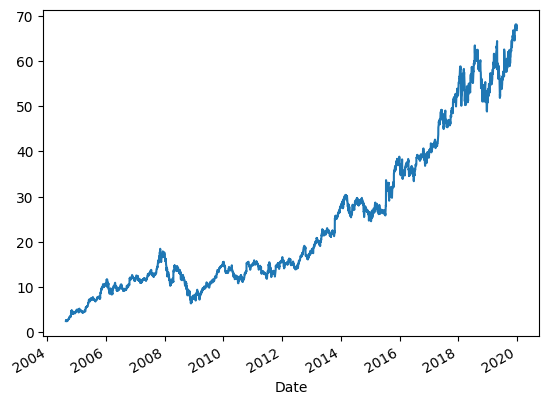

In [ ]:
trainingData['Adj Close'].plot(subplots=True)

In [ ]:
trainprice = trainingData['Adj Close']
trainData = trainprice.values

testprice = testingData['Adj Close']
testData = testprice.values

In [ ]:
trainData


array([ 2.49913311,  2.69763899,  2.724787  , ..., 68.01999664,
       67.59449768, 66.80699921])

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
trainDataScaled = sc.fit_transform(trainData.reshape(-1, 1))
testDataScaled = sc.fit_transform(testData.reshape(-1, 1))

In [ ]:
n_steps = 20 #it means each input sequence to the LSTM will consist of data from the previous 20 days.

xTrain, yTrain = [], []

for i in range(n_steps, len(trainDataScaled)):
    xTrain.append(trainDataScaled[i-n_steps:i, 0])
    yTrain.append(trainDataScaled[i, 0])

xTrain, yTrain = np.array(xTrain), np.array(yTrain)
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))


In [ ]:
#LSTM Model
from tensorflow.keras.regularizers import l2

model = Sequential()

#Layer 1
model.add(LSTM(units=50,return_sequences=True,kernel_regularizer=l2(0.01),input_shape=(xTrain.shape[1], 1)))
model.add(Dropout(0.3))
#Layer 2
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.3))
# #Layer 3
model.add(LSTM(units=50,return_sequences=False))
model.add(Dropout(0.3))
#Layer 4
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
model.summary()

#Early stopping parameters to stop unnecessary training
earlyStopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=15,
    mode='min',
    min_delta = 0.00001
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 20, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 20, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [ ]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [ ]:
#Evaluation of model to confirm if parameters set above are valid
eval = model.evaluate(xTrain, yTrain)

121/121 [==============================] - 7s 15ms/step - loss: 0.2113 - root_mean_squared_error: 0.4377 - mean_absolute_error: 0.3476


In [ ]:
len(xTrain)

3848

Epoch 1/100
23/23 [==============================] - 8s 69ms/step - loss: 0.0206 - root_mean_squared_error: 0.0643 - mean_absolute_error: 0.0539 - val_loss: 0.0364 - val_root_mean_squared_error: 0.1520 - val_mean_absolute_error: 0.1306
Epoch 2/100
23/23 [==============================] - 2s 67ms/step - loss: 0.0323 - root_mean_squared_error: 0.1454 - mean_absolute_error: 0.1228 - val_loss: 0.1051 - val_root_mean_squared_error: 0.3098 - val_mean_absolute_error: 0.2946
Epoch 3/100
23/23 [==============================] - 2s 67ms/step - loss: 0.0259 - root_mean_squared_error: 0.1343 - mean_absolute_error: 0.1175 - val_loss: 0.0661 - val_root_mean_squared_error: 0.2437 - val_mean_absolute_error: 0.2333
Epoch 4/100
23/23 [==============================] - 1s 60ms/step - loss: 0.0111 - root_mean_squared_error: 0.0716 - mean_absolute_error: 0.0608 - val_loss: 0.0110 - val_root_mean_squared_error: 0.0762 - val_mean_absolute_error: 0.0686
Epoch 5/100
23/23 [==============================] - 1s 

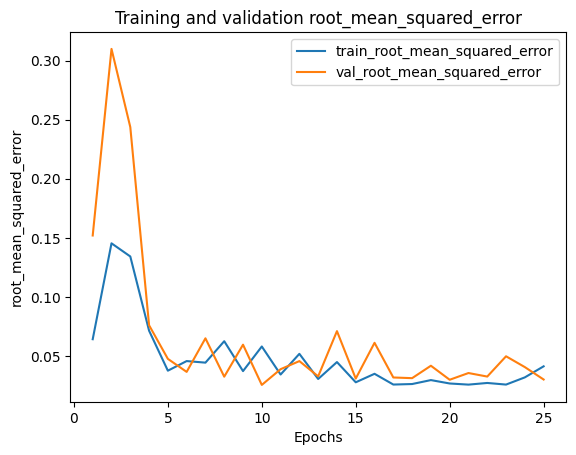

In [ ]:
log = model.fit(
    xTrain,
    yTrain,
    epochs=100,
    batch_size=128,
    validation_split = 0.25,
    verbose=1,
    callbacks=[earlyStopping],
    shuffle=False)
plot_metric(log, 'root_mean_squared_error')

In [ ]:
n_steps = 20

xTest = []
yTest = []

for i in range(n_steps, len(testDataScaled)):
    xTest.append(testDataScaled[i-n_steps:i, 0])
    yTest.append(testDataScaled[i, 0])

xTest, yTest = np.array(xTest), np.array(yTest)
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))


In [ ]:
predictions = model.predict(xTest) #Prediction on Data using trained model
output = sc.inverse_transform(predictions)
rmse = np.sqrt(mean_squared_error(predictions, yTest)) #Calculating of RMSE
rmse

33/33 [==============================] - 1s 9ms/step


0.05516221163982923

In [ ]:
eval = model.evaluate(xTest, yTest) #Calculating of additional metrics (Loss, RMSE, MAE)

33/33 [==============================] - 0s 9ms/step - loss: 0.0036 - root_mean_squared_error: 0.0552 - mean_absolute_error: 0.0432


In [ ]:

df1 = pd.DataFrame(testingData['Adj Close']).astype(float)
df1 = df1.iloc[:-20]
df1 = df1.reset_index(drop=False)

df2 = pd.DataFrame(output, columns = ['Pred Adj Close']).astype(float)


In [ ]:
df = df1.join(df2)
df = df.set_index('Date')
df

,Adj Close,Pred Adj Close
Date,,
2020-01-02,68.368500,73.782700
2020-01-03,68.032997,74.020035
2020-01-06,69.710503,74.246788
2020-01-07,69.667000,74.396935
2020-01-08,70.216003,74.526505
...,...,...
2024-02-23,145.289993,140.750153
2024-02-26,138.750000,141.170364
2024-02-27,140.100006,141.874817


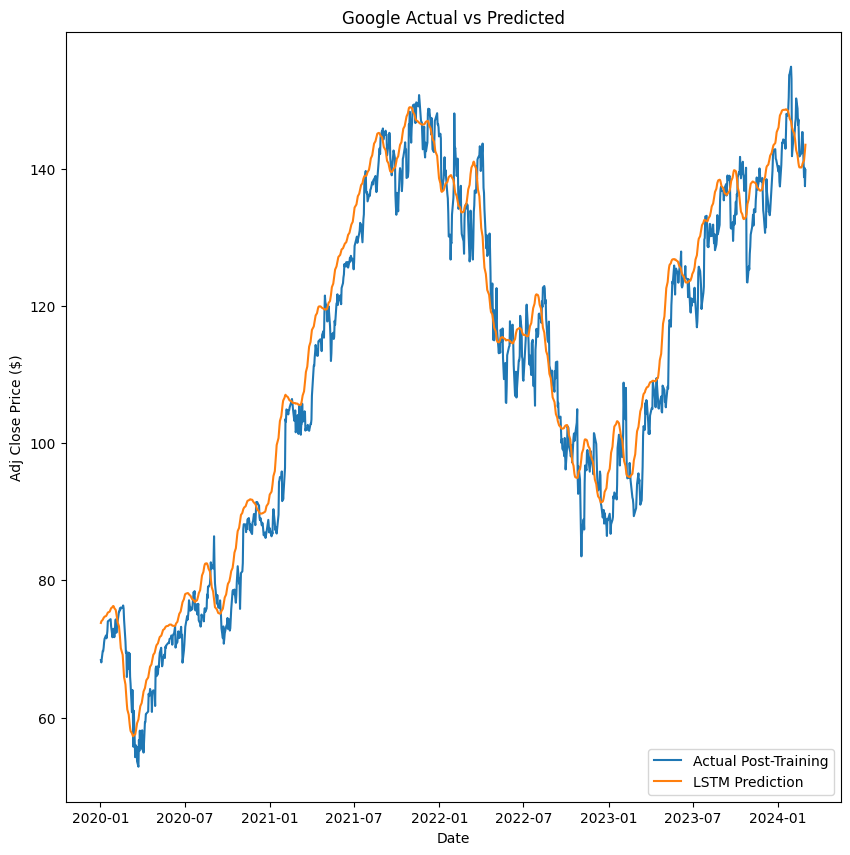

In [ ]:

real = df['Adj Close']
pred = df['Pred Adj Close']
plt.figure(figsize=(10,10))
plt.title('Google Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Adj Close Price ($)')
plt.plot(real)
plt.plot(pred)
plt.legend(['Actual Post-Training','LSTM Prediction'], loc='lower right')

plt.xticks()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

last_sequence = testDataScaled[-n_steps:].reshape(1, n_steps, 1)
future_predictions = []
for _ in range(23):
    next_day_pred = model.predict(last_sequence)
    future_predictions.append(next_day_pred.flatten()[0])
    last_sequence = np.append(last_sequence[:, 1:, :], np.expand_dims(next_day_pred, axis=1), axis=1)

future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = sc.inverse_transform(future_predictions)

last_date = testingData.index.max()
# Using bdate_range to ensure only business days are included
predicted_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=23, freq='B')

predicted_df = pd.DataFrame(future_predictions, index=predicted_dates, columns=['Predicted Adj Close'])
print(predicted_df)


1/1 [==============================] - 0s 22ms/step
            Predicted Adj Close
2024-03-29           144.294464
2024-04-01           145.123581
2024-04-02           145.974121
2024-04-03           146.729736
2024-04-04           147.412567
2024-04-05           147.927902
2024-04-08           148.341248
2024-04-09           148.628418
2024-04-10           148.861221
2024-04-11           149.039200
2024-04-12           149.110611
2024-04-15           149.240067
2024-04-16           149.203278
2024-04-17           149.199081
2024-04-18           149.163788
2024-04-19           149.170410
2024-04-22           149.110168
2024-04-23           149.084290
2024-04-24           149.057022
2024-04-25           149.034927
2024-04-26           149.014084
2024-04-29           149.207458
2024-04-30           149.361099


In [ ]:
predicted_df

,Predicted Adj Close
2024-03-29,144.294464
2024-04-01,145.123581
2024-04-02,145.974121
2024-04-03,146.729736
2024-04-04,147.412567
2024-04-05,147.927902
2024-04-08,148.341248
2024-04-09,148.628418
2024-04-10,148.861221
2024-04-11,149.039200


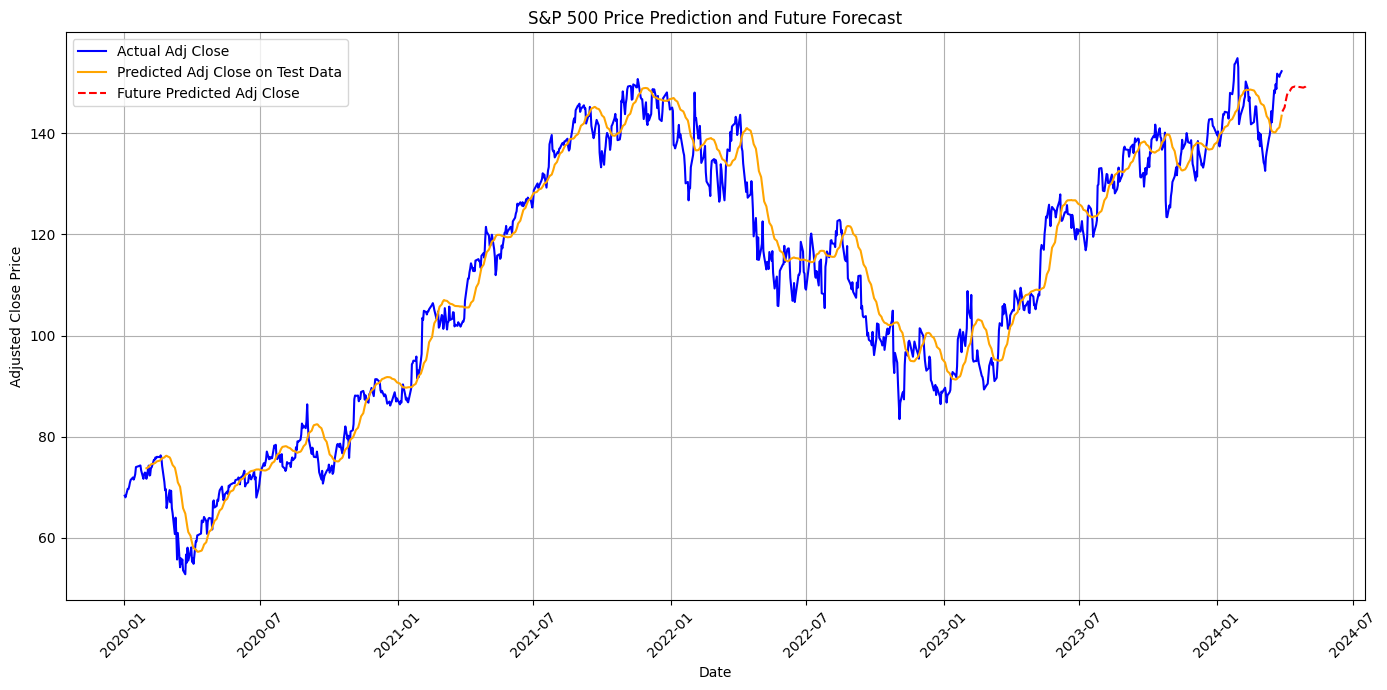

In [ ]:
import matplotlib.pyplot as plt

output_length = len(testingData) - n_steps
output_adjusted = output[:output_length].flatten()
plt.figure(figsize=(14, 7))
plt.plot(testingData.index, testingData['Adj Close'], label='Actual Adj Close', color='blue')
plt.plot(testingData.index[n_steps:], output_adjusted, label='Predicted Adj Close on Test Data', color='orange')
plt.plot(predicted_df.index, predicted_df['Predicted Adj Close'], label='Future Predicted Adj Close', color='red', linestyle='--')
plt.title('Google Price Prediction and Future Forecast')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
